# Google Cloud Natural Language API Demo
#### Further Documentation:
https://cloud.google.com/natural-language/docs
https://cloud.google.com/natural-language/docs/basics
https://cloud.google.com/natural-language/docs/how-to

## Introduction

The Natural Language API has several methods for performing analysis and annotation on your text. Each level of analysis provides valuable information for language understanding. These methods are listed below:

**Sentiment analysis** inspects the given text and identifies the prevailing emotional opinion within the text, especially to determine a writer's attitude as positive, negative, or neutral. This method returns the sentiment of the text as a whole as well as the sentiment of individual sentences within it. Sentiment analysis is performed through the analyzeSentiment method.

**Entity analysis** inspects the given text for known entities (Proper nouns such as public figures, landmarks, and so on. Common nouns such as restaurant, stadium, and so on.) and returns information about those entities. This includes a Wikipedia link (if applicable), the entity type and the salience (a measure of the relevance of the entity to the entire text). Entity analysis is performed with the analyzeEntities method.

**Entity sentiment analysis** inspects the given text for known entities (proper nouns and common nouns), returns information about those entities, and identifies the prevailing emotional opinion of the entity within the text, especially to determine a writer's attitude toward the entity as positive, negative, or neutral. An example of how this might be used is when presented with a sentence that contains a number of different emotions; for example, "I liked the food but the service was terrible". Entity analysis is performed with the analyzeEntitySentiment method.

**Syntactic analysis** extracts linguistic information, breaking up the given text into a series of sentences and tokens (generally, word boundaries), providing further analysis on those tokens. For each word in the text, the API tells you the word's part of speech (noun, verb, adjective, etc.) and how it relates to other words in the sentence. Syntactic Analysis is performed with the analyzeSyntax method.

**Content classification** analyzes text content and returns a content category for the content. Content classification is performed by using the classifyText method.

Each API call also detects and returns the language, if a language is not specified by the caller in the initial request. A full list of supported languages can be found here: https://cloud.google.com/natural-language/docs/languages

Additionally, if you wish to perform several natural language operations on given text using only one API call, the annotateText request can also be used to perform sentiment analysis and entity analysis.


## The Natural Language API: Set Up And Examples

#### Setup

Ensure you have enabled billing, the cloud natural language APIs, and have a service account before running this notebook. 

You may also need to restart your kernel ('Kernel' in the menu). 

In [1]:
pip install --user --upgrade google-cloud-language

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import google-cloud-language
# Make sure that you have installed or upgraded to the latest google-cloud-language using pip
from google.cloud import language_v1 as language
import pandas as pd
#Print all columns and all rows in a panda dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#### Set up functions to call Google Natural Language API
Here are some examples of the API in action <br>
Sentiment Analysis:

In [3]:
# Code from Google at https://codelabs.developers.google.com/codelabs/cloud-natural-language-python3#7
# Probably would be better off changing all the functions to follow the Google standard ones from the codelab, and then making 
# small modifications to the rest of the code to make it all work together.

def analyze_text_sentiment(text):
    client = language.LanguageServiceClient()
    document = language.Document(content=text, type_=language.Document.Type.PLAIN_TEXT)

    response = client.analyze_sentiment(document=document)

    sentiment = response.document_sentiment
    results = dict(
        text=text,
        score=f"{sentiment.score:.1%}",
        magnitude=f"{sentiment.magnitude:.1%}",
    )
    
    # Get sentiment for all sentences in the document
    sentence_sentiment = []
    for sentence in response.sentences:
        item={}
        item["text"]=sentence.text.content
        item["sentiment score"]=sentence.sentiment.score
        item["sentiment magnitude"]=sentence.sentiment.magnitude
        sentence_sentiment.append(item)
    
    return sentence_sentiment

In [15]:
text = "Stocks are going down on the NASDAQ"
analyze_text_sentiment(text)

[{'text': 'Stocks are going down on the NASDAQ',
  'sentiment score': -0.699999988079071,
  'sentiment magnitude': 0.699999988079071}]

Syntactic Analysis:

In [5]:
# Syntax Analysis
def gcp_analyze_syntax(text, debug=0):
    """
    Analyzing Syntax in a String

    Args:
      text The text content to analyze
    """

    client = language.LanguageServiceClient()
    document = language.Document(content=text, type_=language.Document.Type.PLAIN_TEXT)
    response = client.analyze_syntax(document=document)
    
    output = []   
    # Loop through tokens returned from the API
    for token in response.tokens:
        word = {}
        # Get the text content of this token. Usually a word or punctuation.
        text = token.text  

        # Get the part of speech information for this token.
        # Parts of spech are as defined in:
        # http://www.lrec-conf.org/proceedings/lrec2012/pdf/274_Paper.pdf
        part_of_speech = token.part_of_speech
        # Get the tag, e.g. NOUN, ADJ for Adjective, et al.
        
        # Get the dependency tree parse information for this token.
        # For more information on dependency labels:
        # http://www.aclweb.org/anthology/P13-2017
        dependency_edge = token.dependency_edge   
        
        word["word"]=text.content
        word["begin_offset"]=text.begin_offset        
        word["part_of_speech"]=language.PartOfSpeech.Tag(part_of_speech.tag).name
        
        # Get the voice, e.g. ACTIVE or PASSIVE
        word["Voice"]=language.PartOfSpeech.Voice(part_of_speech.voice).name
        word["Tense"]=language.PartOfSpeech.Tense(part_of_speech.tense).name
        
        # See API reference for additional Part of Speech information available
        # Get the lemma of the token. Wikipedia lemma description
        # https://en.wikipedia.org/wiki/Lemma_(morphology)        
        word["Lemma"]=token.lemma
        word["index"]=dependency_edge.head_token_index
        word["Label"]=language.DependencyEdge.Label(dependency_edge.label).name
        
        if debug:
            print(u"Token text: {}".format(text.content))
            print(
                u"Location of this token in overall document: {}".format(text.begin_offset)
            ) 
            print(
                u"Part of Speech tag: {}".format(
                    language.PartOfSpeech.Tag(part_of_speech.tag).name
                )
            )        

            print(u"Voice: {}".format(language.PartOfSpeech.Voice(part_of_speech.voice).name))
            # Get the tense, e.g. PAST, FUTURE, PRESENT, et al.
            print(u"Tense: {}".format(language.PartOfSpeech.Tense(part_of_speech.tense).name))

            print(u"Lemma: {}".format(token.lemma))

            print(u"Head token index: {}".format(dependency_edge.head_token_index))
            print(
                u"Label: {}".format(language.DependencyEdge.Label(dependency_edge.label).name)
            )
        
        output.append(word)
        

    # Get the language of the text, which will be the same as
    # the language specified in the request or, if not specified,
    # the automatically-detected language.
    if debug:
        print(u"Language of the text: {}".format(response.language))
    return (output)

In [6]:
gcp_analyze_syntax(text)

[{'word': 'Stocks',
  'begin_offset': -1,
  'part_of_speech': 'NOUN',
  'Voice': 'VOICE_UNKNOWN',
  'Tense': 'TENSE_UNKNOWN',
  'Lemma': 'stock',
  'index': 2,
  'Label': 'NSUBJ'},
 {'word': 'are',
  'begin_offset': -1,
  'part_of_speech': 'VERB',
  'Voice': 'VOICE_UNKNOWN',
  'Tense': 'PRESENT',
  'Lemma': 'be',
  'index': 2,
  'Label': 'AUX'},
 {'word': 'going',
  'begin_offset': -1,
  'part_of_speech': 'VERB',
  'Voice': 'VOICE_UNKNOWN',
  'Tense': 'PRESENT',
  'Lemma': 'go',
  'index': 2,
  'Label': 'ROOT'},
 {'word': 'down',
  'begin_offset': -1,
  'part_of_speech': 'ADV',
  'Voice': 'VOICE_UNKNOWN',
  'Tense': 'TENSE_UNKNOWN',
  'Lemma': 'down',
  'index': 2,
  'Label': 'ADVMOD'},
 {'word': 'on',
  'begin_offset': -1,
  'part_of_speech': 'ADP',
  'Voice': 'VOICE_UNKNOWN',
  'Tense': 'TENSE_UNKNOWN',
  'Lemma': 'on',
  'index': 2,
  'Label': 'PREP'},
 {'word': 'the',
  'begin_offset': -1,
  'part_of_speech': 'DET',
  'Voice': 'VOICE_UNKNOWN',
  'Tense': 'TENSE_UNKNOWN',
  'Lemma':

Entity Analysis:

In [9]:
# Entity Analysis
def gcp_analyze_entities(text, debug=0):
    """
    Analyzing Entities in a String

    Args:
      text_content The text content to analyze
    """

    client = language.LanguageServiceClient()
    document = language.Document(content=text, type_=language.Document.Type.PLAIN_TEXT)
    response = client.analyze_entities(document=document)
    output = []   
    
    # Loop through entitites returned from the API
    for entity in response.entities:
        item = {}
        item["name"]=entity.name
        item["type"]=language.Entity.Type(entity.type_).name
        item["Salience"]=entity.salience
        
        if debug:
            print(u"Representative name for the entity: {}".format(entity.name))

            # Get entity type, e.g. PERSON, LOCATION, ADDRESS, NUMBER, et al
            print(u"Entity type: {}".format(language.Entity.Type(entity.type_).name))

            # Get the salience score associated with the entity in the [0, 1.0] range
            print(u"Salience score: {}".format(entity.salience))

        # Loop over the metadata associated with entity. For many known entities,
        # the metadata is a Wikipedia URL (wikipedia_url) and Knowledge Graph MID (mid).
        # Some entity types may have additional metadata, e.g. ADDRESS entities
        # may have metadata for the address street_name, postal_code, et al.
        for metadata_name, metadata_value in entity.metadata.items():
            item[metadata_name]=metadata_value
            if debug:
                print(u"{}: {}".format(metadata_name, metadata_value))

        # Loop over the mentions of this entity in the input document.
        # The API currently supports proper noun mentions.
        if debug:
            for mention in entity.mentions:
                print(u"Mention text: {}".format(mention.text.content))
                # Get the mention type, e.g. PROPER for proper noun
                print(
                    u"Mention type: {}".format(language.EntityMention.Type(mention.type_).name)
                )
        output.append(item)
    
    # Get the language of the text, which will be the same as
    # the language specified in the request or, if not specified,
    # the automatically-detected language.
    if debug:
        print(u"Language of the text: {}".format(response.language))
    
    return(output)

     name          type  Salience
0  Stocks         OTHER  0.870346
1  NASDAQ  ORGANIZATION  0.129654


<AxesSubplot:xlabel='None,type'>

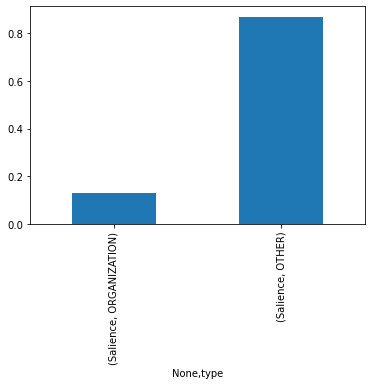

In [10]:
import pandas as pd

consolidate_df = pd.DataFrame()

lines = text.split('.')

for line in lines:
    result = gcp_analyze_entities(line, debug=0)
#     print(result)
    result_df = pd.DataFrame(result)    

    consolidate_df = consolidate_df.append(result_df)
print(consolidate_df.loc[: ,('name', 'type', 'Salience')])

# Group By 'name' or 'type'
consolidate_df.groupby(['type']).sum(['Salience']).unstack().plot(kind='bar')

Content Classification:

In [19]:
# Content Classification

def classify_text(text):
    
    class_list = []
    conf_list = []
    
    client = language.LanguageServiceClient()
    
    document = language.Document(content=text, type_=language.Document.Type.PLAIN_TEXT)
    
    try:
        response = client.classify_text(document=document)
        categories = response.categories
#         print(categories)

        for category in response.categories:
            class_list.append(category.name)
            conf_list.append(category.confidence)
    except:
            class_list.append('/Skipped')
            conf_list.append(0.0)
    
    return class_list, conf_list

A longer piece of text is required.

In [32]:
def classify_result(text, sentence):

    # If sentence == 0, go for the whole text else break into sentences

    # Empty List to append results
    class_result = []
    confi_result = []

    # Split input string into lines
    if sentence == 1:
        lines = text.split('.')

        # For each line of input text, derive classification and confidence score
        for line in lines:

            class_list, conf_list = classify_text(line)
            #     print(class_list, conf_list)

            # A line can contain multiple classifications, list all of them with confidence score
            i = 0
            while len(class_list) > i:

                # If multiple subcategories, Extract the deepest category
                clas = class_list[i].split('/')
                class_result.append(clas[len(clas) - 1])
                confi_result.append(conf_list[i])
                i += 1
    else:
        class_list, conf_list = classify_text(text)

        i = 0
        if len(class_list) > 0:
 
            while len(class_list) > i:
                clas = class_list[i].split('/')

                class_result.append(clas[len(clas) - 1])
                confi_result.append(conf_list[i])
                i += 1


    # Consolidate result into a dataframe
    result_df = pd.DataFrame({'Category': class_result, 'Confidence': confi_result})
    return result_df

<AxesSubplot:xlabel='Category'>

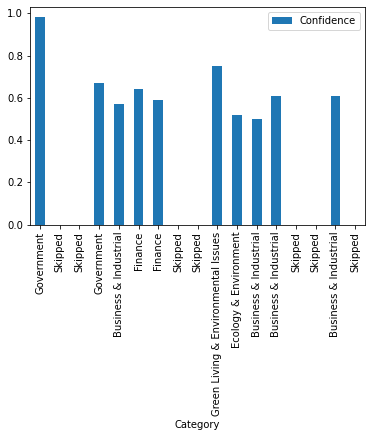

In [34]:
text="Although most people consider piranhas to be quite dangerous, they are, for the most part, entirely harmless. \n\
Piranhas rarely feed on large animals; they eat smaller fish and aquatic plants. When confronted with humans, piranhas’ \n\
first instinct is to flee, not attack. Their fear of humans makes sense. Far more piranhas are eaten by people than people \n\
are eaten by piranhas. If the fish are well-fed, they won’t bite humans."

text="This week Deutsche Bank helped the New Development Bank (NDB) raise the first Sustainable Development Goals (SDG) Panda bond in emerging markets. The NDB is a multilateral development bank established in 2015 by Brazil, Russia, India, China and South Africa (BRICS) with the objective of financing infrastructure and sustainable development projects in BRICS and other emerging and developing countries.The SDG Panda (RMB denominated) issuance, with a coupon of 3.22%, raised 5 billion renminbi (648 million euros) in China’s onshore bond market.  The bond is supported by NDB’s Environmental and Social Framework and issued with reference to the UNDP Sustainable Development Goals Impact Standards for bonds and the SDG Finance Taxonomy (China) and aims to finance sustainable activities and deliver solutions supporting the 17 United Nations’ SDGs in NDB member countries. Deutsche Bank Head of ESG for APAC, Kamran Khan said: This SDG panda bond by NDB demonstrates that multilateral development banks have an important role to play in setting the standards for capital market instruments supporting sustainability and achievement of SDGs, particularly in emerging markets. The capital raised and benchmarks established by this bond will have a very material impact on the standards under which public and private entities raise capital to support the achievement of SDGs in NDB’s member countries. Deutsche Bank was the only European bank selected by the Shanghai headquartered NDB to act as Joint Lead Manager and Joint Bookrunner for the offering. The textile industry employees around 86 million people worldwide, making it a key player in the global economy. It contributes around 2.4 trillion US dollars to global production, but is also responsible for up to ten percent of global greenhouse gas emissions and 20 percent of industrial effluent, according to the UN Alliance for Sustainable Fashion. Furthermore, the garments are made using petroleum-based plastics by low-wage workers, often under dismal conditions for people and the environment. But the textile industry is starting to realise that fast fashion, i.e. rapid production, low quality materials and cheap fashion, is not sustainable: A McKinsey study shows that more than half of the fashion industry’s buying managers now consider sustainability to be one of the most important business strategies and this is having a huge impact on the range of sustainable fashion products. In fact, we are seeing fivefold growth every year!"

result_df = classify_result(text, 1)

result_df.plot(kind='bar', y='Confidence', x='Category')


## Demo 1 - Process a single news article

#### Analyze Syntax
Syntactic Analysis breaks up the given text into a series of sentences and tokens and provides linguistic information about those tokens

In [11]:
text_syntax=gcp_analyze_syntax(text)
df_syntax = pd.DataFrame(text_syntax)
df_syntax

word  begin_offset part_of_speech          Voice          Tense  \
0     Although            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
1         most            -1            ADJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
2       people            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
3     consider            -1           VERB  VOICE_UNKNOWN        PRESENT   
4     piranhas            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
5           to            -1            PRT  VOICE_UNKNOWN  TENSE_UNKNOWN   
6           be            -1           VERB  VOICE_UNKNOWN  TENSE_UNKNOWN   
7        quite            -1            ADV  VOICE_UNKNOWN  TENSE_UNKNOWN   
8    dangerous            -1            ADJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
9            ,            -1          PUNCT  VOICE_UNKNOWN  TENSE_UNKNOWN   
10        they            -1           PRON  VOICE_UNKNOWN  TENSE_UNKNOWN   
11         are            -1           VERB  VOICE_UNKNOWN        PRESENT   
12           ,            -1          PUNCT  VOICE_UNKNOWN  TENSE_UNKNOWN   
13         for            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
14         the            -1            DET  VOICE_UNKNOWN  TENSE_UNKNOWN   
15        most            -1            ADJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
16        part            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
17           ,            -1          PUNCT  VOICE_UNKNOWN  TENSE_UNKNOWN   
18    entirely            -1            ADV  VOICE_UNKNOWN  TENSE_UNKNOWN   
19    harmless            -1            ADJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
20           .            -1          PUNCT  VOICE_UNKNOWN  TENSE_UNKNOWN   
21    Piranhas            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
22      rarely            -1            ADV  VOICE_UNKNOWN  TENSE_UNKNOWN   
23        feed            -1           VERB  VOICE_UNKNOWN        PRESENT   
24          on            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
25       large            -1            ADJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
26     animals            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
27           ;            -1          PUNCT  VOICE_UNKNOWN  TENSE_UNKNOWN   
28        they            -1           PRON  VOICE_UNKNOWN  TENSE_UNKNOWN   
29         eat            -1           VERB  VOICE_UNKNOWN        PRESENT   
30     smaller            -1            ADJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
31        fish            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
32         and            -1           CONJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
33     aquatic            -1            ADJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
34      plants            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
35           .            -1          PUNCT  VOICE_UNKNOWN  TENSE_UNKNOWN   
36        When            -1            ADV  VOICE_UNKNOWN  TENSE_UNKNOWN   
37  confronted            -1           VERB  VOICE_UNKNOWN           PAST   
38        with            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
39      humans            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
40           ,            -1          PUNCT  VOICE_UNKNOWN  TENSE_UNKNOWN   
41    piranhas            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
42           ’            -1            PRT  VOICE_UNKNOWN  TENSE_UNKNOWN   
43       first            -1            ADJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
44    instinct            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
45          is            -1           VERB  VOICE_UNKNOWN        PRESENT   
46          to            -1            PRT  VOICE_UNKNOWN  TENSE_UNKNOWN   
47        flee            -1           VERB  VOICE_UNKNOWN  TENSE_UNKNOWN   
48           ,            -1          PUNCT  VOICE_UNKNOWN  TENSE_UNKNOWN   
49         not            -1            ADV  VOICE_UNKNOWN  TENSE_UNKNOWN   
50      attack            -1           VERB  VOICE_UNKNOWN  TENSE_UNKNOWN   
51    

#### Analyze Entities
Entity Analysis inspects the given text for known entities (proper nouns such as public figures, landmarks, etc.), and returns information about those entities.

In [12]:
entities=gcp_analyze_entities(text)
df_entities = pd.DataFrame(entities)
df_entities

name      type  Salience
0   piranhas     OTHER  0.639721
1     people    PERSON  0.122904
2       part     OTHER  0.039671
3     humans    PERSON  0.039253
4     people    PERSON  0.022413
5   piranhas     OTHER  0.018652
6       fish     OTHER  0.014871
7   instinct     OTHER  0.014522
8     plants  LOCATION  0.013237
9    animals     OTHER  0.013077
10  piranhas     OTHER  0.012863
11      fear     OTHER  0.012051
12      fish     OTHER  0.010050
13    humans    PERSON  0.007914
14  piranhas     OTHER  0.005665
15    humans    PERSON  0.004991
16    people    PERSON  0.004978
17     sense     OTHER  0.003168

#### Classify Documents
Google Natual Language API classifies documents into these major categories: <br>
Adult

Arts & Entertainment

Autos & Vehicles

Beauty & Fitness

Books & Literature

Business & Industrial

Computers & Electronics

Finance

Food & Drink

Games

Health

Hobbies & Leisure

Home & Garden

Internet & Telecom

Jobs & Education

Law & Government

News

Online Communities

People & Society

Pets & Animals

Real Estate

Reference

Science

Sensitive Subjects

Shopping

Sports

Travel

A full list of categories and subcategories could be found here: https://cloud.google.com/natural-language/docs/categories

#### Analyze Sentiment
Interpreting Google Sentiment Analysis Values:

Sentiment Score - a number from -1.0 to 1.0 indicating how positive or negative the statement is.

Sentiment Magnitude - a number ranging from 0 to infinity that represents the weight of sentiment expressed in the statement, regardless of being positive or negative. This value is often proportional to the length of the document.

In [13]:
# sentiment, magnitude, sentence_sentiment=gcp_analyze_sentiment(text) <- never declared
sentence_sentiment = analyze_text_sentiment(text)

text      : Although most people consider piranhas to be quite dangerous, they are, for the most part, entirely harmless. 
Piranhas rarely feed on large animals; they eat smaller fish and aquatic plants. When confronted with humans, piranhas’ 
first instinct is to flee, not attack. Their fear of humans makes sense. Far more piranhas are eaten by people than people 
are eaten by piranhas. If the fish are well-fed, they won’t bite humans.
score     : -20.0%
magnitude : 190.0%


In [14]:
df_sentiment = pd.DataFrame(sentence_sentiment)
df_sentiment

text  sentiment score  \
0  Although most people consider piranhas to be q...              0.3   
1  Piranhas rarely feed on large animals; they ea...             -0.4   
2  When confronted with humans, piranhas’ \nfirst...             -0.5   
3                  Their fear of humans makes sense.             -0.3   
4  Far more piranhas are eaten by people than peo...              0.0   
5  If the fish are well-fed, they won’t bite humans.             -0.4   

   sentiment magnitude  
0                  0.3  
1                  0.4  
2                  0.5  
3                  0.3  
4                  0.0  
5                  0.4

## Demo 2 - Process sample news articles from Refinitiv

In [22]:
from google.cloud import storage

# news_sample="github/gcp/FinancialServicesHeadline100.csv" 
# news_sample="gs://ml-core-shared-standard-bucket/data/FinancialServicesHeadline100.csv"
# df = pd.read_csv(news_sample)
df = pd.read_csv('reuters_headlines.csv')
print(df.shape)
df.head()

(99, 2)


Headlines         Time
0  TikTok considers London and other locations fo...  Jul 18 2020
1  Disney cuts ad spending on Facebook amid growi...  Jul 18 2020
2  Trail of missing Wirecard executive leads to B...  Jul 18 2020
3  Twitter says attackers downloaded data from up...  Jul 18 2020
4  U.S. Republicans seek liability protections as...  Jul 17 2020

In [23]:
text=df["Headlines"]
print("size of document:", text.shape)
text.head()

size of document: (99,)


0    TikTok considers London and other locations fo...
1    Disney cuts ad spending on Facebook amid growi...
2    Trail of missing Wirecard executive leads to B...
3    Twitter says attackers downloaded data from up...
4    U.S. Republicans seek liability protections as...
Name: Headlines, dtype: object

In [24]:
# Combine all news into one document
text_all= df["Headlines"].to_string(index=False)
#print(text_all)

#### Analyze Syntax
Syntactic Analysis breaks up the given text into a series of sentences and tokens and provides linguistic information about those tokens

In [25]:
# Process each news as a separate document

df_text_syntax=pd.DataFrame()
for text in df["Headlines"]:
    item=gcp_analyze_syntax(text)
    df_text_syntax=df_text_syntax.append(pd.DataFrame(item))


In [26]:
print("size of output:", df_text_syntax.shape)
df_text_syntax.head(50)

size of output: (1174, 8)


word  begin_offset part_of_speech          Voice          Tense  \
0         TikTok            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
1      considers            -1           VERB  VOICE_UNKNOWN        PRESENT   
2         London            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
3            and            -1           CONJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
4          other            -1            ADJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
5      locations            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
6            for            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
7   headquarters            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
0         Disney            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
1           cuts            -1           VERB  VOICE_UNKNOWN        PRESENT   
2             ad            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
3       spending            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
4             on            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
5       Facebook            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
6           amid            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
7        growing            -1           VERB  VOICE_UNKNOWN  TENSE_UNKNOWN   
8        boycott            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
9              :            -1          PUNCT  VOICE_UNKNOWN  TENSE_UNKNOWN   
10           WSJ            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
0          Trail            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
1             of            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
2        missing            -1           VERB  VOICE_UNKNOWN  TENSE_UNKNOWN   
3       Wirecard            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
4      executive            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
5          leads            -1           VERB  VOICE_UNKNOWN        PRESENT   
6             to            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
7        Belarus            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
8              ,            -1          PUNCT  VOICE_UNKNOWN  TENSE_UNKNOWN   
9            Der            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
10       Spiegel            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
11       reports            -1           VERB  VOICE_UNKNOWN        PRESENT   
0        Twitter            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
1           says            -1           VERB  VOICE_UNKNOWN        PRESENT   
2      attackers            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
3     downloaded            -1           VERB  VOICE_UNKNOWN           PAST   
4           data            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
5           from            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
6             up            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
7             to            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
8          eight            -1            NUM  VOICE_UNKNOWN  TENSE_UNKNOWN   
9   non-verified            -1            ADJ  VOICE_UNKNOWN  TENSE_UNKNOWN   
10      accounts            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
0           U.S.            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
1    Republicans            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
2           seek            -1           VERB  VOICE_UNKNOWN        PRESENT   
3      liability            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
4    protections            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
5             as            -1            ADP  VOICE_UNKNOWN  TENSE_UNKNOWN   
6    coronavirus            -1           NOUN  VOICE_UNKNOWN  TENSE_UNKNOWN   
7            aid            -1           NOUN  VOICE_UNKNOWN  

#### Analyze Entities
Entity Analysis inspects the given text for known entities (proper nouns such as public figures, landmarks, etc.), and returns information about those entities.

In [27]:
# Process each article independently

df_entities=pd.DataFrame()
for text in df["Headlines"]:
    item=pd.DataFrame(gcp_analyze_entities(text))
    df_entities=df_entities.append(item, ignore_index=True)
# entities=gcp_analyze_entities(text_all)
# df_entities2 = pd.DataFrame(entities)

In [28]:
print("size of output:", df_entities.shape)
df_entities.head(50)

size of output: (469, 8)


name          type  Salience  \
0                      TikTok        PERSON  0.445297   
1                   locations      LOCATION  0.203937   
2                      London      LOCATION  0.193428   
3                headquarters      LOCATION  0.157338   
4                      Disney  ORGANIZATION  0.480582   
5                 ad spending         OTHER  0.230572   
6                    Facebook         OTHER  0.142777   
7                     boycott         OTHER  0.075107   
8                         WSJ  ORGANIZATION  0.070962   
9                       Trail      LOCATION  0.543633   
10                  executive        PERSON  0.163996   
11                   Wirecard  ORGANIZATION  0.145212   
12                    Belarus      LOCATION  0.093570   
13                Der Spiegel        PERSON  0.053589   
14                    Twitter  ORGANIZATION  0.437248   
15                  attackers        PERSON  0.305469   
16                       data         OTHER  0.145661   
17                   accounts         OTHER  0.111622   
18                      eight        NUMBER  0.000000   
19                Republicans        PERSON  0.351088   
20                       U.S.      LOCATION  0.351088   
21      liability protections         OTHER  0.173773   
22     coronavirus aid battle         EVENT  0.124051   
23           Wall Street Week   WORK_OF_ART  0.488371   
24              Fund managers        PERSON  0.239066   
25   Night of the Living Dead   WORK_OF_ART  0.149100   
26                       caps         OTHER  0.123463   
27                   earnings         OTHER  0.606844   
28                    V-shape         OTHER  0.393156   
29                       Five        NUMBER  0.000000   
30                  Evictions         OTHER  0.533454   
31                     levels         OTHER  0.164851   
32                       U.S.      LOCATION  0.093513   
33                      study         OTHER  0.083802   
34              Cleveland Fed  ORGANIZATION  0.071167   
35                      areas         OTHER  0.053213   
36                     Google  ORGANIZATION  0.360357   
37                        ads   WORK_OF_ART  0.315409   
38                coronavirus         OTHER  0.189183   
39  conspiracy theory content         OTHER  0.135051   
40                     Flight         OTHER  0.427340   
41                    suburbs      LOCATION  0.185746   
42               homebuilding      LOCATION  0.129072   
43                       U.S.      LOCATION  0.078275   
44                   COVID-19      LOCATION  0.072898   
45         consumer sentiment         OTHER  0.065289   
46                      surge         EVENT  0.041380   
47                         19        NUMBER  0.000000   
48                      Delta  ORGANIZATION  0.690033   
49            pilot furloughs         OTHER  0.139017   

                                        wikipedia_url            mid value  \
0                https://en.wikipedia.org/wiki/TikTok  /g/11f555cn8l   NaN   
1                                                 NaN            NaN   NaN   
2                https://en.wikipedia.org/wiki/London       /m/04jpl   NaN   
3                                                 NaN            NaN   NaN   
4   https://en.wikipedia.org/wiki/The_Walt_Disney_...       /m/09b3v   NaN   
5                                                 NaN            NaN   NaN   
6              https://en.wikipedia.org/wiki/Facebook      /m/02y1vz   NaN   
7                                                 NaN            NaN   NaN   
8   https://en.wikipedia.org/wiki/The_Wall_Street_...      /m/017b3j   NaN   
9                                                 NaN            NaN   NaN   
10                                                NaN            NaN   NaN   
11             https://en.wikipedia.org/wiki/Wirecard     /m/02qqv74   NaN   
12              https://en.wikipedia.org/wiki/Belarus       /m/0163v   NaN   
13  https://en.wikipedia.

#### Classify Documents
Google Natual Language API classifies documents into these major categories: <br>
Adult

Arts & Entertainment

Autos & Vehicles

Beauty & Fitness

Books & Literature

Business & Industrial

Computers & Electronics

Finance

Food & Drink

Games

Health

Hobbies & Leisure

Home & Garden

Internet & Telecom

Jobs & Education

Law & Government

News

Online Communities

People & Society

Pets & Animals

Real Estate

Reference

Science

Sensitive Subjects

Shopping

Sports

Travel

A full list of categories and subcategories could be found here:
https://cloud.google.com/natural-language/docs/categories

In [29]:
## Overall document classification
gcp_classify_text(text_all)

category  : /Business & Industrial
confidence: 88%
category  : /News/Business News
confidence: 76%


In [41]:
# Process each article independently

df_sentiment=pd.DataFrame()
item_sentiment=pd.DataFrame(columns=["text", "sentiment score","sentiment magnitude"])
for text in df["Headlines"]:
    sentiment_output = analyze_text_sentiment(text)
    item_sentiment.loc[0, "text"]=sentiment_output[0].get('text')
    item_sentiment.loc[0, "sentiment score"]= sentiment_output[0].get('sentiment score')
    item_sentiment.loc[0,"sentiment magnitude"]= sentiment_output[0].get('sentiment magnitude')
    
    df_sentiment=df_sentiment.append(item_sentiment, ignore_index=True)

In [42]:
df_sentiment.head(100)

text sentiment score  \
0   TikTok considers London and other locations fo...             0.0   
1   Disney cuts ad spending on Facebook amid growi...            -0.7   
2   Trail of missing Wirecard executive leads to B...            -0.4   
3   Twitter says attackers downloaded data from up...            -0.4   
4   U.S. Republicans seek liability protections as...            -0.1   
5   Wall Street Week Ahead: Fund managers navigate...             0.0   
6      Take Five: Hoping for that V-shape in earnings             0.3   
7   Evictions nearly back to pre-pandemic levels i...             0.0   
8   Google bans ads on coronavirus conspiracy theo...            -0.6   
9   Flight to suburbs boosts U.S. homebuilding, bu...             0.0   
10  Delta will avoid pilot furloughs if they agree...            -0.3   
11  S&P 500 ends higher as traders weigh stimulus ...             0.6   
12  FTC considering deposing top Facebook executiv...             0.0   
13                        Where did all the bulls go?            -0.3   
14  BlackRock profit beats Street estimates as mar...             0.1   
15  Dollar falls, euro hovers at four-month high a...             0.0   
16  Boohoo tells UK Home Secretary it is probing c...            -0.6   
17  Exclusive: EU in talks with Moderna, BioNtech,...             0.1   
18  Former Pemex boss arrives back in Mexico for g...            -0.1   
19  Twitter says about 130 accounts were targeted ...            -0.5   
20  Senator asks Twitter about claim worker was pa...            -0.3   
21  Treasury's Mnuchin open to blanket forgiveness...             0.3   
22  On eve of bankruptcy, U.S. firms shower execs ...             0.0   
23  Rival parties take aim at Germany's Scholz ove...            -0.5   
24  U.S. economy faces significant risks, long roa...            -0.6   
25  Euro zone shares flat as EU recovery plan awai...             0.0   
26  Cohen's Point72 to open Warsaw office for some...             0.0   
27  In Utah, a debate stirs over Estonian radioact...            -0.6   
28  End of the jumbo: British Airways retires 747 ...            -0.1   
29  Fed opens 'Main Street' loan program to nonpro...             0.6   
30  As big U.S. banks let customers delay payments...            -0.7   
31  UBS, Morgan Stanley expected to lead Vodafone ...             0.0   
32  Exclusive: Thyssenkrupp to explore further opt...             0.2   
33  Icelandair to sack cabin crew but keep flying ...            -0.5   
34  Economic recovery further away than markets th...            -0.5   
35  EasyJet pilots say they have no confidence in ...            -0.8   
36  Exclusive: HSBC sheds top talent as global equ...             0.8   
37  Lloyds Bank sets target to increase number of ...             0.1   
38  Wall Street analysts look past Netflix's weak ...            -0.3   
39  Exclusive: Pact to aid poor cocoa farmers in p...            -0.5   
40  Italy plans listing for Autostrade by early 20...             0.0   
41  German abattoir scandal puts cooling systems u...            -0.3   
42  Former Pemex boss Lozoya taken to hospital aft...            -0.2   
43  Bored bank customers flock to day-trading plat...             0.0   
44  Stripe wins business following Wirecard's coll...            -0.1   
45  Indonesian tycoon Salim wins close shareholder...            -0.3   
46  EU regulators halt LSE, Refinitiv probe, await...             0.0   
47  Lyft to provide drivers with partition shields...            -0.2   
48  Deutsche Boerse proposes new rules for quick D...            -0.2   
49  Daimler to stop building sedans in the U.S. af...            -0.4   
50  Volkswagen expects single-digit sales decline ...            -0.6   
51  Coronavirus surge, renewed lockdowns fan fresh...             0.5   
52  United Airlines, pilots union reach creative d...             0.1   
53  Netflix names content chief Ted Sarandos co-CE...            -0.6   
54  Westpac says regulator-ordered

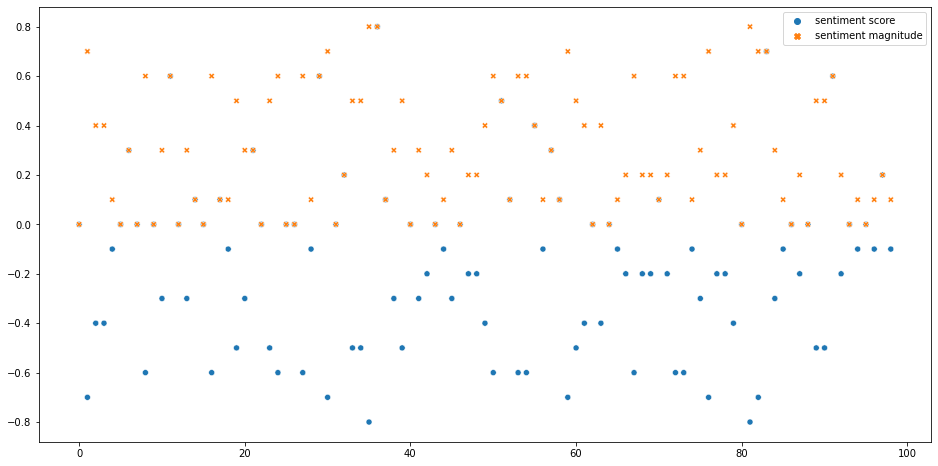

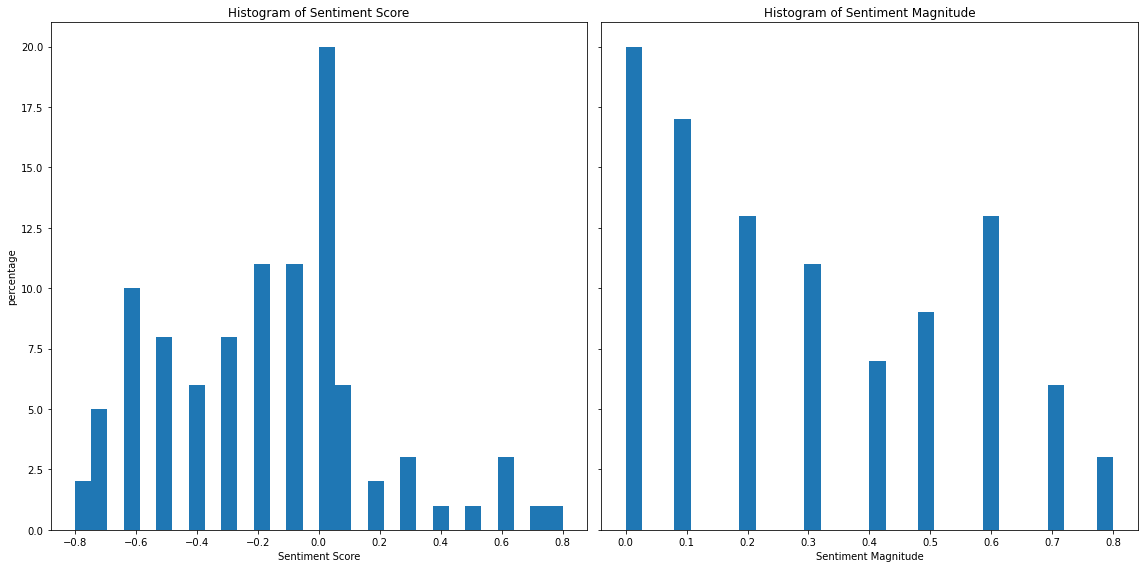

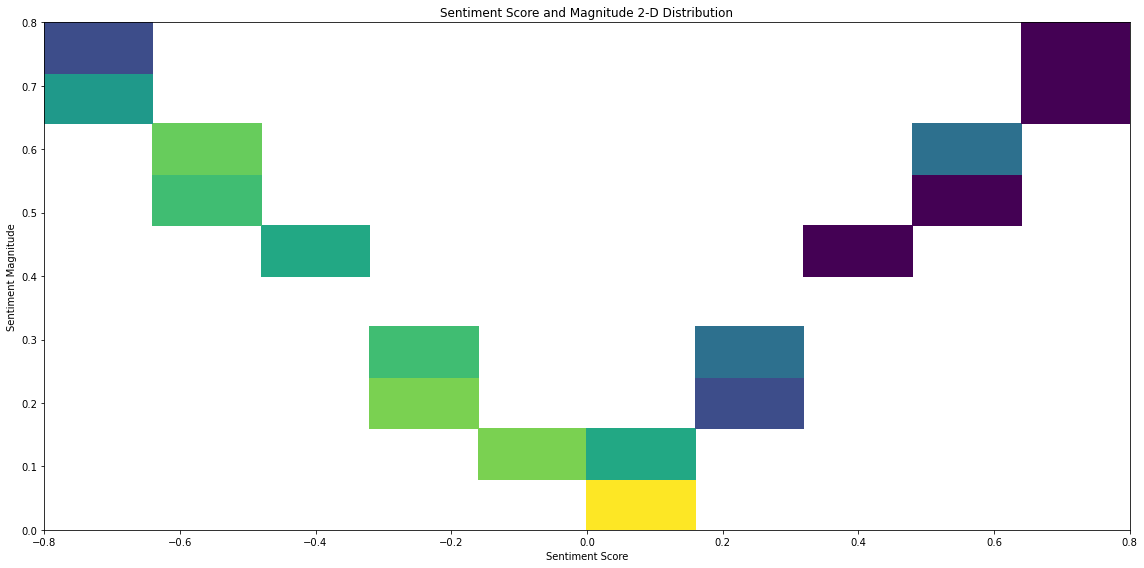

In [43]:
# Plot Sentiment Scores
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({'figure.figsize':(16,8)})

x = df_sentiment["sentiment score"]
y =  df_sentiment["sentiment magnitude"]

sns.scatterplot(data= df_sentiment[["sentiment score", "sentiment magnitude"]])
                
n_bins=30

#plt.hist(x, bins=n_bins)
#plt.show()

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
# We can set the number of bins with the `bins` kwarg
axs[0].set_xlabel("Sentiment Score")
axs[0].set_ylabel("percentage")
axs[0].set_title('Histogram of Sentiment Score')
axs[1].set_xlabel("Sentiment Magnitude")
axs[1].set_title('Histogram of Sentiment Magnitude')

axs[0].hist(x, bins=n_bins)
axs[1].hist(y, bins=n_bins)
plt.show()


fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist2d(x, y, norm=colors.LogNorm())
plt.title("Sentiment Score and Magnitude 2-D Distribution")
ax.set_xlabel("Sentiment Score")
ax.set_ylabel("Sentiment Magnitude")

plt.show()